In [165]:
import pandas as pd
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras 
from keras.models import Sequential
from keras.layers import BatchNormalization,MaxPool2D,Dense,Conv2D,Flatten
from keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Dropout

In [166]:
data = pd.read_csv('/Users/mikid/Downloads/age_gender.csv')

In [167]:
data.shape

(23705, 5)

In [168]:
data.head(100)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
95,1,2,0,20161219204848341.jpg.chip.jpg,133 213 218 221 216 207 184 211 220 239 235 24...
96,1,2,0,20161219204858548.jpg.chip.jpg,62 55 97 148 169 187 194 189 191 197 195 190 1...
97,1,2,0,20161219204634589.jpg.chip.jpg,200 204 205 207 208 212 213 216 217 217 215 21...
98,1,2,0,20161219204951309.jpg.chip.jpg,245 236 239 234 220 233 237 216 234 214 208 21...


## Preprocessing

In [169]:
data.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [170]:
data['img_name'].value_counts()

20170110173815028.jpg.chip.jpg    7
20170112213001988.jpg.chip.jpg    6
20170116232936514.jpg.chip.jpg    5
20170112213500903.jpg.chip.jpg    4
20170117145704297.jpg.chip.jpg    4
                                 ..
20170116172439655.jpg.chip.jpg    1
20170117165412909.jpg.chip.jpg    1
20170117020452350.jpg.chip.jpg    1
20170109204120279.jpg.chip.jpg    1
20170116222759439.jpg.chip.jpg    1
Name: img_name, Length: 23479, dtype: int64

In [171]:
column = data["age"]
max_value = column.max()
min_value = column.min()


print(f'youngest age: {min_value} years')

print(f'oldest age: {max_value} years')



youngest age: 1 years
oldest age: 116 years


<AxesSubplot:>

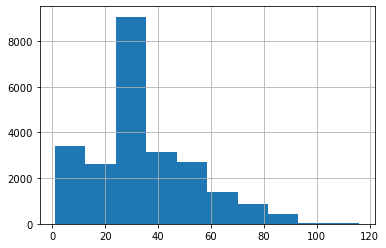

In [172]:
data['age'].hist()

<AxesSubplot:>

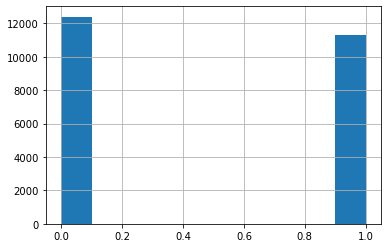

In [173]:
data['gender'].hist()

<AxesSubplot:>

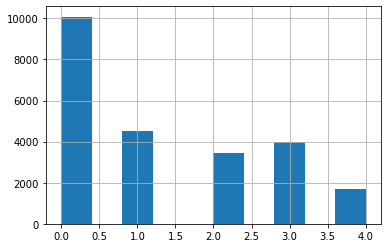

In [174]:
data['ethnicity'].hist()

In [175]:
print(len(data['pixels'][0].split(' ')))
print(np.sqrt(2304))


2304
48.0


In [176]:
print(np.sqrt(2304))

48.0


In [177]:
num_pixels = 2304
img_height = 48
img_width = 48

In [178]:
target_columns = ['age']

y = data[target_columns]
X = data.drop(target_columns, axis=1)

In [179]:
y

,age
0,1
1,1
2,1
3,1
4,1
...,...
23700,99
23701,99
23702,99
23703,99


## Neuro Network Solution

Shaping the pixels into 48 x48 images

In [180]:
def values_to_array(pixels):
    arr=np.array(pixels.split(),'float64')
    arr=arr.reshape(48,48)
#     print(arr.shape)
    return arr
data['pixels']=data['pixels'].apply(values_to_array)

## Training Data

In [181]:
train_img,test_img,train_age,test_age=train_test_split(data['pixels'],data['age'],test_size=0.2,random_state=42)

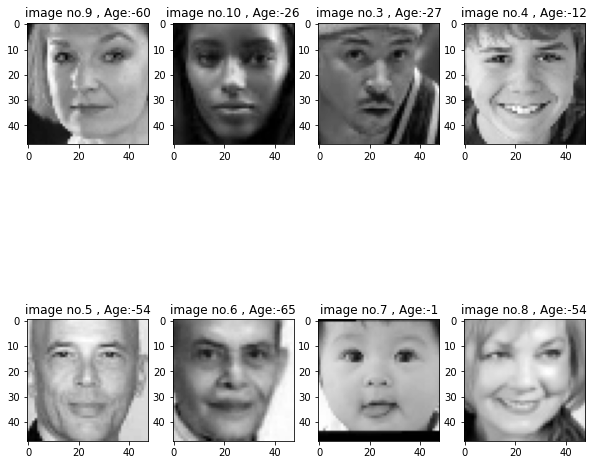

In [126]:
plt.figure(figsize=(10,10))
for i in range(0,10):
    plt.subplot(2,4,(i%8)+1)
    num=np.random.randint(0, 2000)
    plt.title("image no.{0} , Age:-{1}".format(i+1,train_age.iloc[num]))
    plt.imshow(train_img.iloc[num],cmap='gray')
plt.show()

In [182]:
def change_image_dimension(data):
    data=np.reshape(data.to_list(),(len(data),48,48,1))
    return data

In [183]:
train_img=change_image_dimension(train_img)
test_img=change_image_dimension(test_img)
# train_img
train_img=train_img/255.0
test_img=test_img/255.0

In [184]:
len(train_img)

18964

In [185]:
len(test_img)

4741

## AGE MODEL

In [186]:
def schedule(epoch,lr):
    if epoch>=5:
        return 0.0001
    return 0.001
early_stop=EarlyStopping(monitor='val_mean_absolute_error',patience=4, restore_best_weights=True)
learning_rate_scheduler=LearningRateScheduler(schedule)
reduceLR=ReduceLROnPlateau(monitor='val_mean_absolute_error',patience=2,min_lr=0.00001, verbose=1)

Building the Network:

Below is the final structure: This only items that were tweaked over 25 or more iterations are in the fully 
connected network. The first layer initially had 264 units, followed by 128 units.  This resulted in massive 
overfitting.  I proceeded to reduce each of the layer by half. The model still was overfitting. Next, I tried 
L2 regularization on each Dense Layer. I then tried L1 regularization. I settled on using L2 regularization. 
I next included two dropout layers (.20). This created a slight underfitting of the model. I then reduced the 
dropout rate to .10 which resulted in overfitting again. I tuned the dropout rate with the following iterations 
.12, .15, and .17.   This tuning resulted in an almost fitted model.


In [187]:
model=Sequential()
model.add(Conv2D(128,(3,3),activation='relu',input_shape=(48,48,1)))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128,activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.18))
model.add(Dense(32,activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.18))
model.add(Dense(1,activation='relu'))

In [188]:
model.compile(optimizer='adam',loss='mse',metrics=[keras.metrics.mean_absolute_error])
r=model.fit(train_img,train_age,validation_data=(test_img,test_age),epochs=300,callbacks=[reduceLR,early_stop ])

Epoch 1/300
593/593 [==============================] - 52s 85ms/step - loss: 357.7222 - mean_absolute_error: 13.6381 - val_loss: 1072.9934 - val_mean_absolute_error: 29.5414
Epoch 2/300
593/593 [==============================] - 51s 86ms/step - loss: 141.0945 - mean_absolute_error: 8.7325 - val_loss: 221.2184 - val_mean_absolute_error: 10.4045
Epoch 3/300
593/593 [==============================] - 52s 87ms/step - loss: 117.2849 - mean_absolute_error: 7.8529 - val_loss: 97.7808 - val_mean_absolute_error: 7.1516
Epoch 4/300
593/593 [==============================] - 53s 89ms/step - loss: 107.2168 - mean_absolute_error: 7.4340 - val_loss: 125.4650 - val_mean_absolute_error: 8.3773
Epoch 5/300
593/593 [==============================] - 54s 91ms/step - loss: 100.0722 - mean_absolute_error: 7.2274 - val_loss: 104.1402 - val_mean_absolute_error: 7.4490

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/300
593/593 [==============================] - 53s 8

In [115]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 46, 46, 128)       1280      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 23, 23, 128)       512       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 21, 21, 64)        73792     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 10, 10, 64)        256       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 8, 8, 32)        

In [116]:
fig = px.line(
    r.history,
    y=['mean_absolute_error', 'val_mean_absolute_error'],
    labels={'index': "Epoch", 'value': "mean_absolute_error]"},
    title="Age Model"
)

fig.show()

In [117]:
pred_train_Age=model.predict(train_img)
train_age=np.array(train_age,'int32')
pred_train_Age=np.reshape(pred_train_Age,(len(train_age),))
train_age=np.reshape(train_age,(len(train_age),))
train_images=np.reshape(train_img,(len(train_img),48,48))

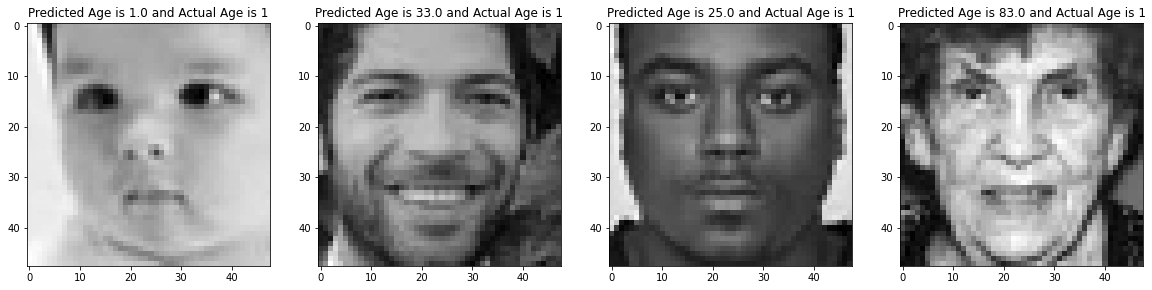

In [132]:

plt.figure(figsize=(20,15))
for i in range(10,15):
    plt.subplot(1,4,(i%4)+1)
    plt.title("Predicted Age is {0} and Actual Age is {1}".format(np.round(pred_train_Age[i]),train_age[i]))
    plt.imshow(train_images[i],cmap='gray')
plt.show()

In [199]:
pred_train_Age.shape


(18964,)

In [ ]:
model.predict(train_img)

In [195]:
model.predict(test_img)

array([[24.137186 ],
       [39.92945  ],
       [ 6.0532146],
       ...,
       [ 6.6807647],
       [48.70974  ],
       [52.425003 ]], dtype=float32)

In [204]:
test_age.shape


(4741,)

In [202]:
print(test_img.shape)
test_images=np.reshape(test_img,(len(test_img),48,48))
print(test_images)

(4741, 48, 48, 1)
[[[0.12156863 0.1254902  0.10980392 ... 0.20392157 0.18039216 0.19607843]
  [0.1372549  0.11764706 0.10588235 ... 0.19607843 0.17254902 0.18431373]
  [0.12156863 0.11764706 0.12156863 ... 0.14509804 0.19215686 0.19215686]
  ...
  [0.09019608 0.07843137 0.06666667 ... 0.11372549 0.09803922 0.08235294]
  [0.09019608 0.07843137 0.07058824 ... 0.09803922 0.08627451 0.06666667]
  [0.07843137 0.06666667 0.05098039 ... 0.10196078 0.09803922 0.09019608]]

 [[0.72941176 0.25490196 0.14901961 ... 0.61960784 0.60784314 0.6       ]
  [0.37647059 0.16078431 0.1372549  ... 0.62745098 0.61568627 0.59607843]
  [0.19607843 0.14509804 0.14509804 ... 0.63137255 0.61176471 0.58823529]
  ...
  [0.76078431 0.78431373 0.77647059 ... 0.         0.         0.        ]
  [0.77254902 0.80784314 0.79215686 ... 0.         0.         0.        ]
  [0.76078431 0.79607843 0.77647059 ... 0.         0.         0.        ]]

 [[0.07843137 0.09019608 0.1372549  ... 0.29803922 0.23529412 0.19607843]
  [0

In [203]:
model.score(test_img, test_age)

AttributeError: 'Sequential' object has no attribute 'score'

test_img

In [205]:
mean_absolute_error(test_age,pred_train_Age)

InvalidArgumentError: Incompatible shapes: [18964] vs. [4741] [Op:Sub]